## SpaceShip Titanic 

Réalisé par : Imane BOUKHARI,
Lynda CHABOUNI,
Léo BEN HATAT,
Khady CAMARA DANSO

# 1. Etude préalable des données 
## 1.1. Analyse des fichiers 

Librairies et extensions 

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
sns.set(style="whitegrid")


Importation des données

In [272]:
chemin = 'Données/train.csv'
df = pd.read_csv(chemin)
display(df.head())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Liste des variables présentes dans le dataset

| **Nom de la variable** | **Description** |
|:----------------------:|:---------------:|
| PassengerId | Un identifiant unique pour chaque passager. Chaque identifiant prend la forme de gggg_pp, où gggg indique le groupe avec lequel le passager voyage et pp est son numéro au sein du groupe. Les membres d'un groupe sont souvent des membres de la famille, mais pas toujours. |
| HomePlanet | La planète d'où le passager est parti, généralement sa planète de résidence permanente. |
| CryoSleep | Indique si le passager a choisi d'être mis en animation suspendue pendant la durée du voyage. Les passagers en cryosleep sont confinés dans leurs cabines. |
| Cabin | Le numéro de cabine où le passager séjourne. Il prend la forme de pont/numéro/côté, où le côté peut être soit P pour bâbord, soit S pour tribord. (deck/num/side) |
| Destination | Planète de destination |
| Age | Âge du passager |
| VIP | Indique si le passager a payé pour un service VIP spécial pendant le voyage. |
| RoomService | Dépenses en Room Service |
| FoodCourt | Dépenses au Food Court |
| ShoppingMall | Dépenses au Shopping Mall |
| Spa | Dépenses au Spa |
| VRDeck | Dépenses au VR Deck |
| Name | Prénom et nom du passager |
| Transported |  Indique si le passager a été transporté vers une autre dimension. Il s'agit de la cible, la colonne que vous essayez de prédire. |

# 1.2 Traitement des valeurs manquantes et aberrantes

In [273]:
# Statistiques descriptives globales
stats = df.describe(include='all').T
stats['% de valeurs manquantes'] = 100 * df.isnull().sum() / len(df)
display(stats)

# Tableau synthétique des valeurs manquantes
manquantes = pd.DataFrame({
    'Nom': df.columns,
    'Total de valeurs': len(df),
    'Total de valeurs manquantes': df.isnull().sum().values,
    'Pourcentage de valeurs manquantes': 100 * df.isnull().sum().values / len(df)
})
manquantes = manquantes[manquantes['Total de valeurs manquantes'] > 0]
manquantes = manquantes[['Nom', 'Total de valeurs', 'Total de valeurs manquantes', 'Pourcentage de valeurs manquantes']]
manquantes.sort_values('Total de valeurs manquantes', ascending=False, inplace=True)
display(manquantes.style.format({'Pourcentage de valeurs manquantes': '{:.2f}%'}).set_caption('Valeurs manquantes par variable'))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,% de valeurs manquantes
PassengerId,8693,8693,0001_01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
HomePlanet,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.312205
CryoSleep,8476,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.496261
Cabin,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.289198
Destination,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.093639
Age,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0,2.059128
VIP,8490,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.335212
RoomService,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0,2.082135
FoodCourt,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0,2.105142
ShoppingMall,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0,2.392730


,Nom,Total de valeurs,Total de valeurs manquantes,Pourcentage de valeurs manquantes
2,CryoSleep,8693,217,2.50%
9,ShoppingMall,8693,208,2.39%
6,VIP,8693,203,2.34%
1,HomePlanet,8693,201,2.31%
12,Name,8693,200,2.30%
3,Cabin,8693,199,2.29%
11,VRDeck,8693,188,2.16%
8,FoodCourt,8693,183,2.11%
10,Spa,8693,183,2.11%
4,Destination,8693,182,2.09%


Vérification des doublons

In [274]:
duplicates = df.duplicated()
print("\nNumber of duplicates :", duplicates.sum())

if duplicates.any():
    print("\nLines with duplicates :")
    print(df[duplicates])


Number of duplicates : 0


Nous visualisons la distribution des variables numériques et détectons les valeurs aberrantes à l'aide de la méthode de l'IQR. Les outliers sont remplacés par la médiane pour préserver la distribution.

In [275]:
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col} : {outliers} valeurs aberrantes détectées")
    mediane = df[col].median()
    df.loc[df[col] < lower, col] = mediane
    df.loc[df[col] > upper, col] = mediane

Age : 77 valeurs aberrantes détectées
RoomService : 1861 valeurs aberrantes détectées
FoodCourt : 1823 valeurs aberrantes détectées
ShoppingMall : 1829 valeurs aberrantes détectées
Spa : 1788 valeurs aberrantes détectées
VRDeck : 1809 valeurs aberrantes détectées


In [276]:
# Crear df_outliers a partir del archivo original (sin haber reemplazado outliers en el df modificado)
chemin = 'Données/train.csv'
df_raw = pd.read_csv(chemin)

# Columnas numéricas
num_cols = df_raw.select_dtypes(include=np.number).columns

# Diccionario que guardará las máscaras de outliers por columna
outlier_cols = {}

# Máscara global para filas que son outliers en al menos una columna
outlier_mask = pd.Series(False, index=df_raw.index)

for col in num_cols:
    Q1 = df_raw[col].quantile(0.25)
    Q3 = df_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df_raw[col] < lower) | (df_raw[col] > upper)
    outlier_cols[col] = mask
    outlier_mask = outlier_mask | mask

# DataFrame con todas las filas que tienen al menos un outlier
df_outliers = df_raw[outlier_mask].copy()

# Añadir columna que lista las columnas donde cada fila es outlier
df_outliers['OutlierColumns'] = df_outliers.index.to_series().apply(lambda i: [col for col, m in outlier_cols.items() if m.loc[i]])

# Flag booleano
df_outliers

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,OutlierColumns
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,[Spa]
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,"[FoodCourt, Spa]"
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,"[FoodCourt, ShoppingMall, Spa, VRDeck]"
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,"[RoomService, ShoppingMall, Spa]"
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,"[FoodCourt, Spa]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,9275_03,Europa,NaN,A/97/P,TRAPPIST-1e,30.0,False,0.0,3208.0,0.0,2.0,330.0,Atlasym Conable,True,"[FoodCourt, VRDeck]"
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,"[FoodCourt, Spa]"
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,[ShoppingMall]
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,"[FoodCourt, Spa, VRDeck]"


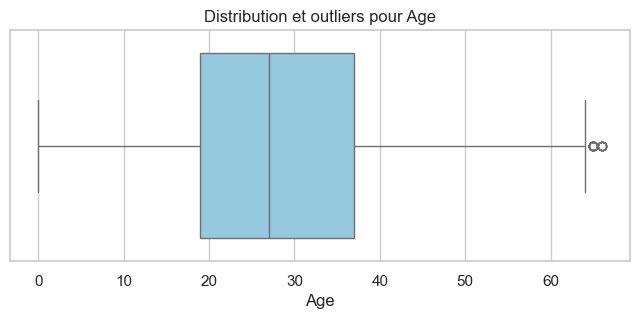

Age : 30 valeurs aberrantes détectées


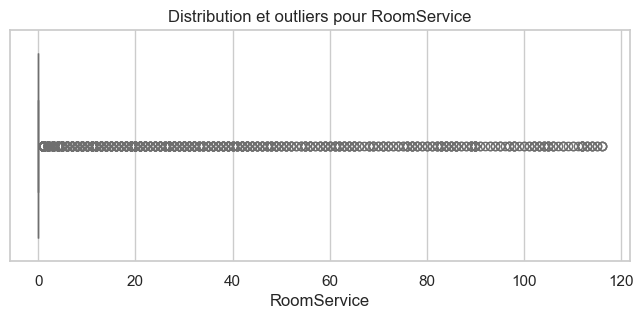

RoomService : 1074 valeurs aberrantes détectées


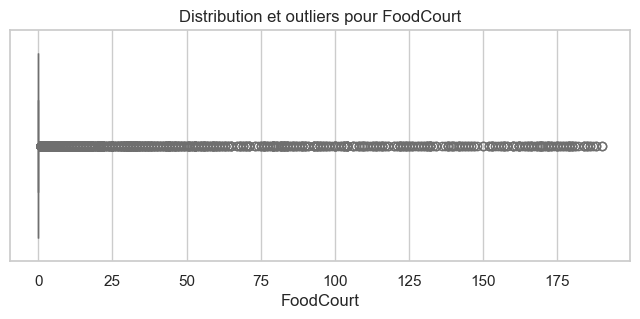

FoodCourt : 1231 valeurs aberrantes détectées


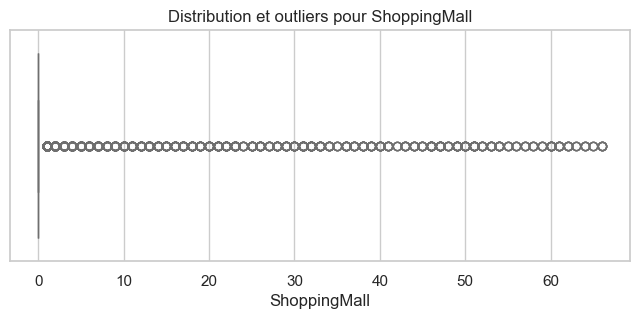

ShoppingMall : 1069 valeurs aberrantes détectées


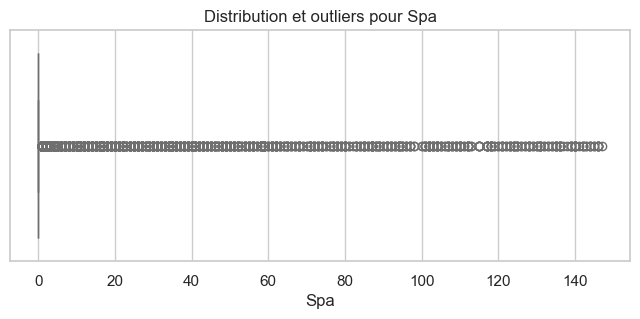

Spa : 1398 valeurs aberrantes détectées


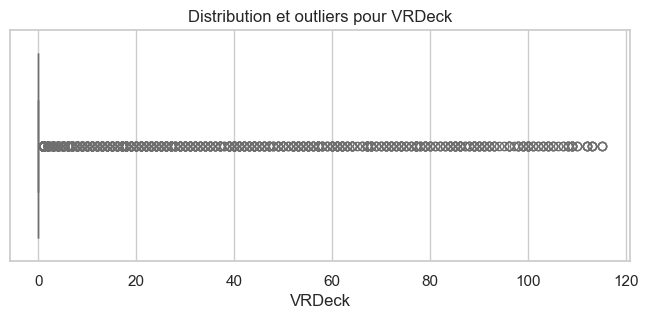

VRDeck : 1201 valeurs aberrantes détectées


In [277]:
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Distribution et outliers pour {col}')
    plt.show()
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col} : {outliers} valeurs aberrantes détectées")
    mediane = df[col].median()
    df.loc[df[col] < lower, col] = mediane
    df.loc[df[col] > upper, col] = mediane

## 1.3 Imputation des valeurs manquantes 

Les valeurs manquantes sont imputées : la médiane pour les variables numériques et la modalité la plus fréquente (mode) pour les variables catégorielles. Cette étape est essentielle pour garantir la qualité des analyses ultérieures.

In [278]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

C:\Users\222569\AppData\Local\Temp\ipykernel_8828\3055292169.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\222569\AppData\Local\Temp\ipykernel_8828\3055292169.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(df[col].mode()[0], inpl

# 1.3 Variables ajoutées

In [279]:

# A. Exploitation de PassengerId (Group & IsAlone)
df['Group'] = df['PassengerId'].str.split('_').str[0]

df['GroupSize'] = df.groupby('Group')['Group'].transform('count')

df['IsAlone'] = (df['GroupSize'] == 1).astype(int)


# B. Découpage de la cabine (Deck, Num, Side)
df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split('/', expand=True)


# C. Analyse des dépenses
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df['TotalSpent'] = df[exp_features].sum(axis=1)

df['HasSpent'] = (df['TotalSpent'] > 0).astype(int)


# D. Nom de famille et taille de la famille
df['FamilyName'] = df['Name'].str.split().str[-1]

df['FamilySize'] = df.groupby('FamilyName')['FamilyName'].transform('count')

df['HasFamily'] = (df['FamilySize'] > 1).astype(int)

# Vérification rapide
df.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,GroupSize,IsAlone,Deck,CabinNum,Side,TotalSpent,HasSpent,FamilyName,FamilySize,HasFamily
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,1,1,B,0,P,0.0,0,Ofracculy,1,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,...,1,1,F,0,S,0.0,0,Vines,4,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,0.0,0.0,0.0,...,2,0,A,0,S,0.0,0,Susent,6,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,...,2,0,A,0,S,0.0,0,Susent,6,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,...,1,1,F,1,S,0.0,0,Santantines,6,1


# 2. Statistiques descriptives

## 2.1 Statistiques Univariées

### 2.1.1 Variables numériques 

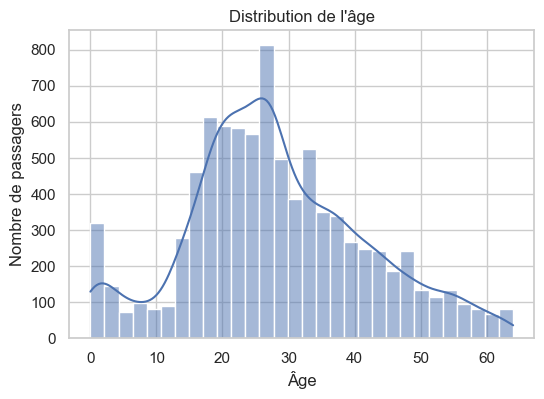

In [280]:
plt.figure(figsize=(6,4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Distribution de l'âge")
plt.xlabel("Âge")
plt.ylabel("Nombre de passagers")
plt.show()


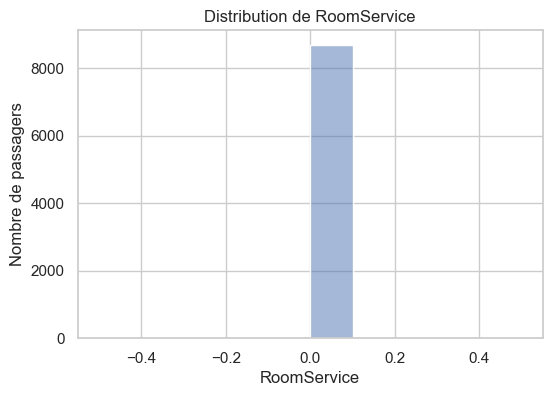

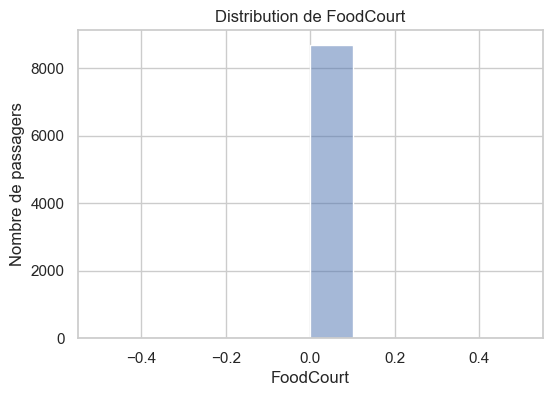

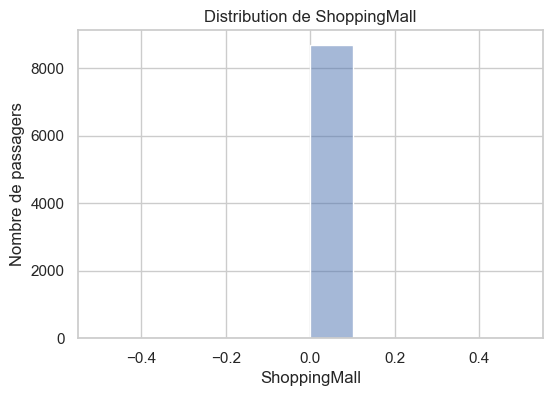

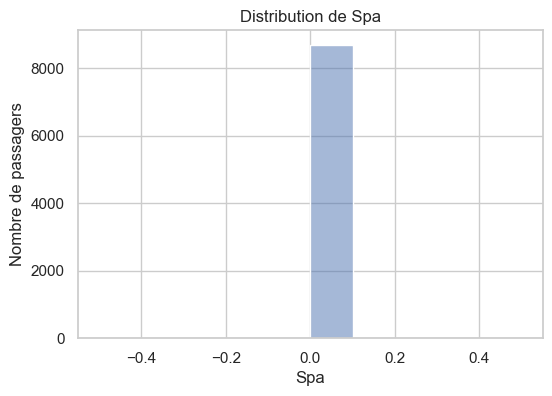

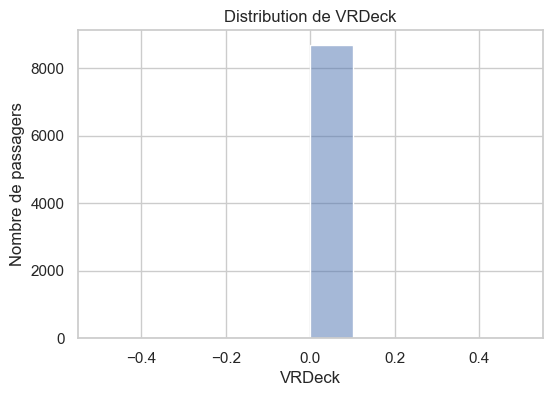

In [281]:
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in exp_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=10, kde=True)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Nombre de passagers")
    plt.show()


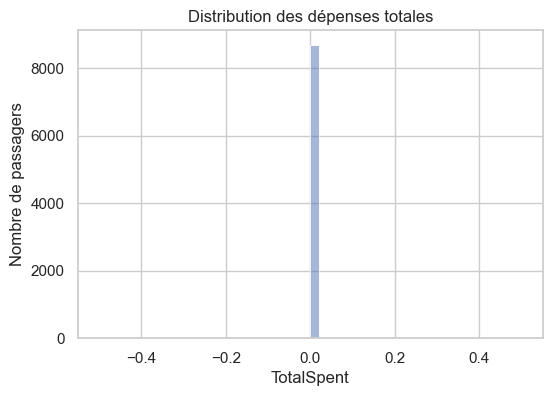

In [282]:
plt.figure(figsize=(6,4))
sns.histplot(df['TotalSpent'], bins=50, kde=True)
plt.title("Distribution des dépenses totales")
plt.xlabel("TotalSpent")
plt.ylabel("Nombre de passagers")
plt.show()


### 2.1.2 Variables catégorielles 

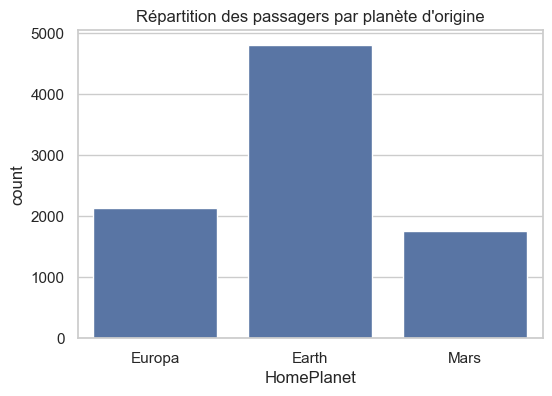

In [283]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='HomePlanet')
plt.title("Répartition des passagers par planète d'origine")
plt.show()


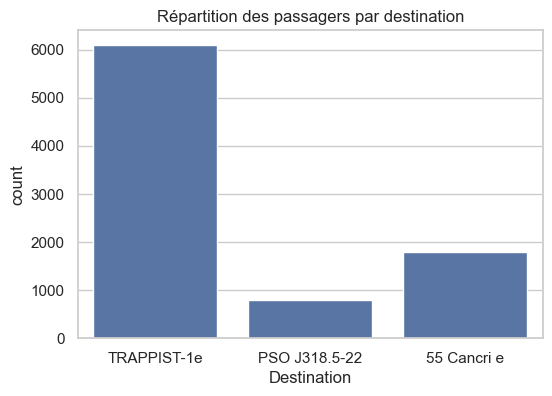

In [284]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Destination')
plt.title("Répartition des passagers par destination")
plt.show()


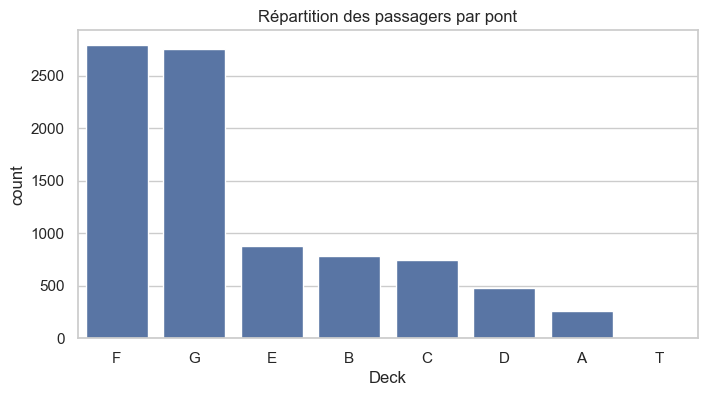

In [285]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Deck', order=df['Deck'].value_counts().index)
plt.title("Répartition des passagers par pont")
plt.show()


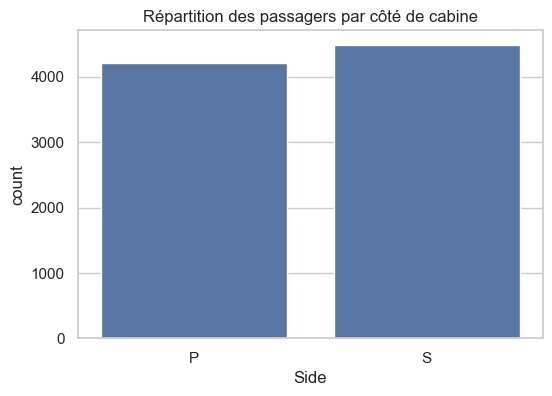

In [286]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Side')
plt.title("Répartition des passagers par côté de cabine")
plt.show()


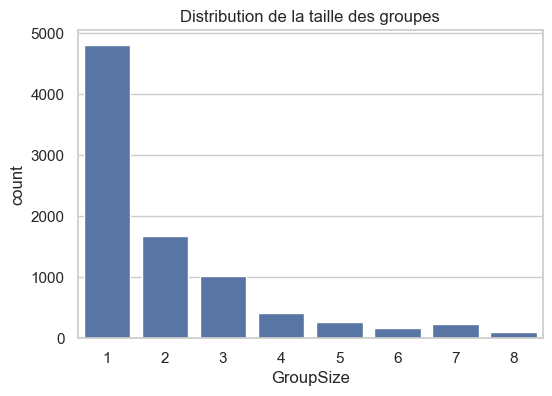

In [287]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='GroupSize')
plt.title("Distribution de la taille des groupes")
plt.show()


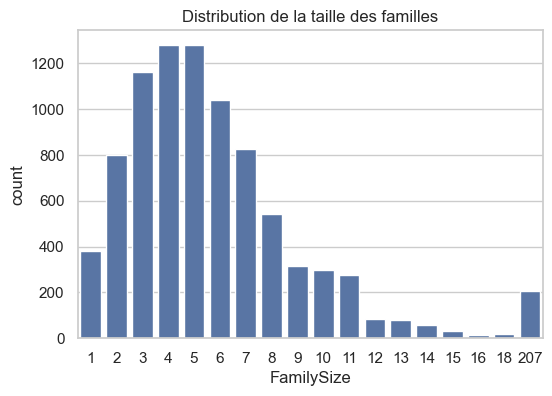

In [288]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='FamilySize')
plt.title("Distribution de la taille des familles")
plt.show()


### 2.1.3 Variables binaires

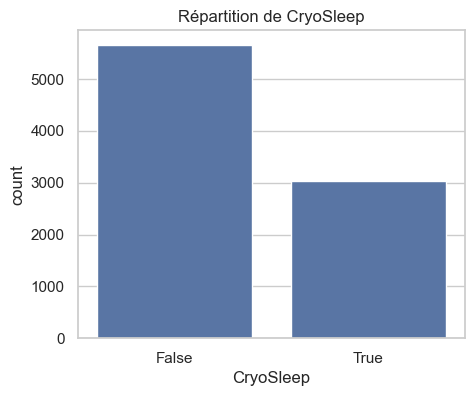

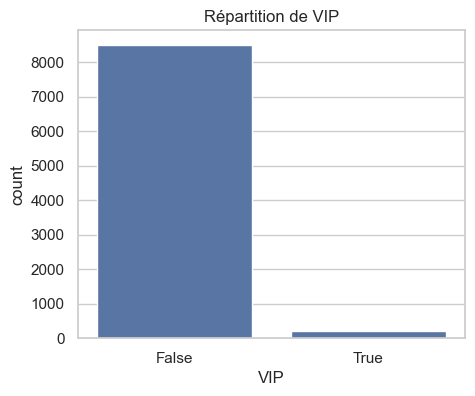

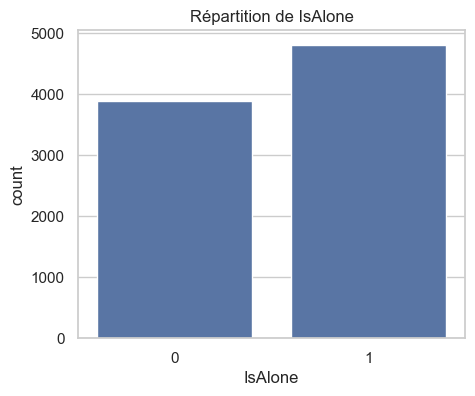

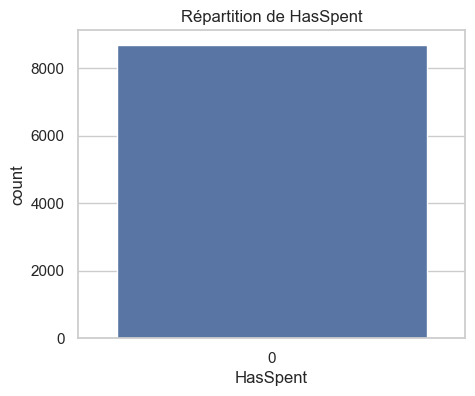

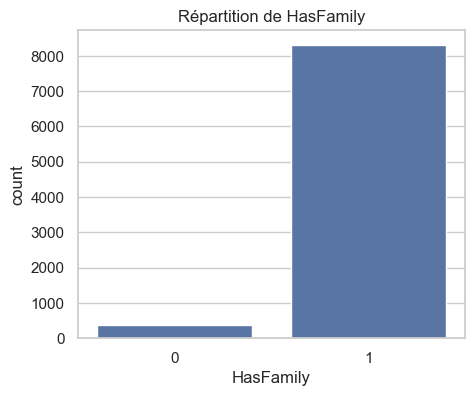

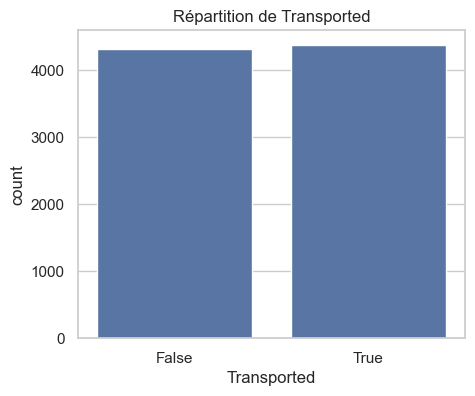

In [289]:
binary_vars = [
    'CryoSleep', 'VIP', 'IsAlone', 'HasSpent', 'HasFamily', 'Transported'
]

for col in binary_vars:
    plt.figure(figsize=(5,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Répartition de {col}")
    plt.show()


## 2.2 Statistiques bivariées 

Verification de la coherence des données (cryogénisé et depenses)

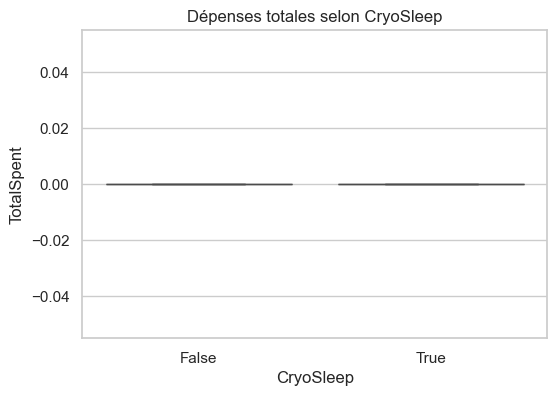

In [290]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='CryoSleep', y='TotalSpent')
plt.title("Dépenses totales selon CryoSleep")
plt.show()


Analyse des relations entre variables catégorielles avec le V de Cramer

Nous analysons la force des relations entre les variables catégorielles à l'aide du V de Cramer et visualisons la matrice de corrélation obtenue. La diagonale est fixée à 1 pour une meilleure lisibilité.

C:\Users\222569\AppData\Local\Temp\ipykernel_8828\409340160.py:30: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\222569\AppData\Local\Temp\ipykernel_8828\409340160.py:30: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\222569\AppData\Local\Temp\ipykernel_8828\409340160.py:30: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\222569\AppData\Local\Temp\ipykernel_8828\409340160.py:30: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\222569\AppData\Local\Temp\ipykernel_8828\409340160.py:30: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\222569\AppData\Local\Temp\ipykernel_8828\409340160.py:30: RuntimeWarning: invalid valu

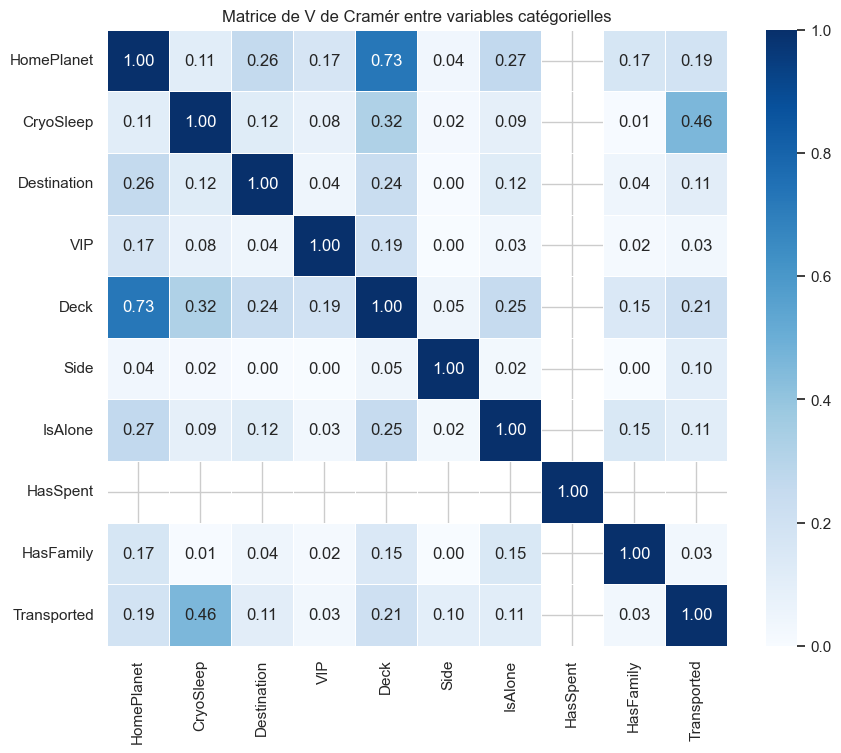

In [291]:
# ================================
# SELECTION DES VARIABLES CATEGORIELLES
# ================================
# Exclure les colonnes à trop forte cardinalité
cat_cols = [
    'HomePlanet',
    'CryoSleep',
    'Destination',
    'VIP',
    'Deck',
    'Side',
    'IsAlone',
    'HasSpent',
    'HasFamily',
    'Transported'
]

# ================================
# FONCTION V DE CRAMER
# ================================
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# ================================
# CALCUL DE LA MATRICE DE V DE CRAMER
# ================================
cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramer_matrix = cramer_matrix.astype(float)
np.fill_diagonal(cramer_matrix.values, 1)

# ================================
# HEATMAP
# ================================
plt.figure(figsize=(10, 8))
sns.heatmap(
    cramer_matrix,
    annot=True,
    cmap='Blues',
    fmt='.2f',
    linewidths=0.5
)
plt.title("Matrice de V de Cramér entre variables catégorielles")
plt.show()